In [1]:
# Bayesian PCA adapted from https://gist.github.com/twiecki/c95578a6539d2098be2d83575e3d15fe
%matplotlib inline

import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import theano.tensor as tt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

## Generate 3d data with random covariance

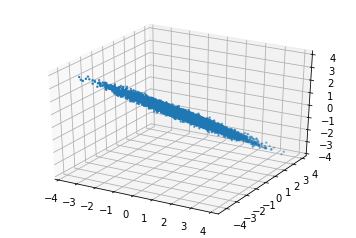

In [2]:
N = 10000 
M = 3  # dimensions of the data
D = 2  # dimensions of the projection

np.random.seed(10)
C = np.random.randn(M, M)
C = np.dot(C.T, C)
X = np.random.multivariate_normal(np.zeros(shape=(M, )), C, size=N)
# In the general case we subtract the mean and divide by std, 
X = X - np.mean(X, axis=0)
X = X/np.std(X, axis=0)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=2)

## Scikit learn PCA

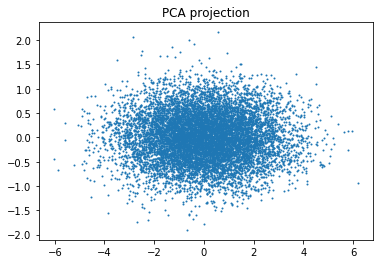

In [3]:
pca = PCA(n_components=2, whiten=False)
R = pca.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(R[:, 0], R[:, 1], s=1)
_ = plt.title('PCA projection')

## Probabilistic PCA using PyMC3

- Latent variable has an isotropic gaussian prior, $z \sim \mathcal{N}(0, 1)$
- The conditional likelihod is $x|z \sim \mathcal{N}(Wz + \mu, I\sigma^2)$
- W is the axis transformation for the latent variable
- We learn W, $\mu$ and $\sigma$ using ADVI
- In this case we omit $\mu$ because the data is already centered
- When $\sigma^2 \to 0$ the conventional PCA is recovered
- **TODO:** BETTER PRIOR FOR w

Average Loss = 24,729: 100%|██████████| 2000/2000 [00:11<00:00, 170.65it/s]
Finished [100%]: Average Loss = 24,724


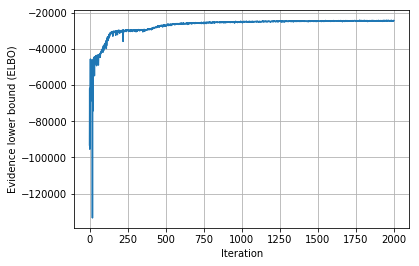

In [4]:
with pm.Model() as PPCA:
    s = pm.HalfCauchy('s', beta=5, shape=[1,])
    w = pm.Normal('w', mu=tt.zeros([D, M]), sd=tt.ones([D, M]), shape=[D, M])
    z = pm.Normal('z', mu=tt.zeros([N, D]), sd=tt.ones([N, D]), shape=[N, D])
    x = pm.Normal('x', mu=z.dot(w), sd=s*tt.ones([N, M]), shape=[N, M], observed=X)  
    inference = pm.ADVI()
    approx = pm.fit(n=2000, method=inference, obj_optimizer=pm.adam(learning_rate=1e-1))

_ = plt.plot(-inference.hist)
plt.ylabel('Evidence lower bound (ELBO)')
plt.xlabel('Iteration')
plt.grid()

We sample the parameters from the variational posterior (this is not like MCMC) and plot distributions for W and $\sigma$

100%|██████████| 100/100 [00:00<00:00, 266.60it/s]


Average W
[[ 0.78447597  0.78981126 -0.84047635]
 [ 0.34573397 -0.26521303  0.03848782]]
Average sigma: 0.179490


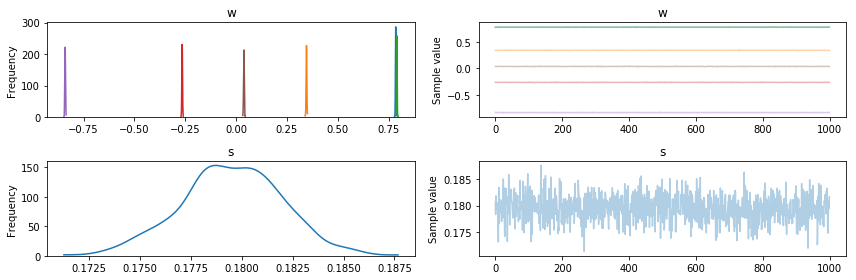

In [5]:
with PPCA:
    trace = approx.sample(draws=1000)
    ppc = pm.sample_ppc(trace=trace, samples=100)
_ = pm.traceplot(trace=trace, varnames=['w', 's'])

W_avg = np.mean(trace['w'], axis=0)
s_avg = np.mean(trace['s'], axis=0)
print("Average W")
print(W_avg)
print("Average sigma: %f" %(s_avg))

We can sample X from the conditional to see if its close to the original data

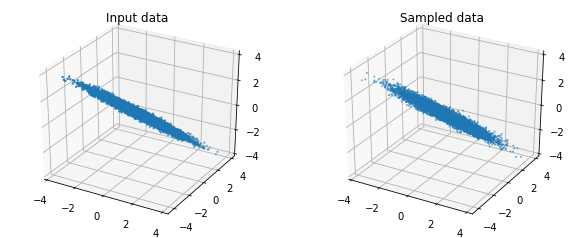

In [6]:
x_reconstructed = ppc['x'][0, :, :]  # this is one draw from the posterior

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=2)
ax.set_title('Input data')             
bx, by, bz = ax.get_xbound(), ax.get_ybound(), ax.get_zbound()      
ax = fig.add_subplot(122, projection='3d')
ax.set_title("Sampled data")
ax.scatter(x_reconstructed[:, 0], x_reconstructed[:, 1], x_reconstructed[:, 2], s=1, alpha=0.5)
t = np.linspace(-4, 4, num=100)
ax.set_xbound(bx)
ax.set_ybound(by)
ax.set_zbound(bz)


The projections from the average trace plus errorbars and also computed by hand, i.e. the mean of the posterior p(z|x)

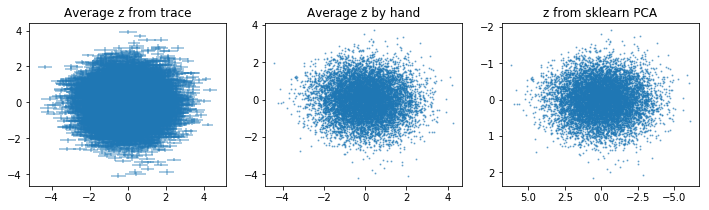

In [8]:
z_trace_avg = np.mean(trace['z'], axis=0)
z_trace_std = np.std(trace['z'], axis=0)
z_trace_var = np.mean(np.var(trace['z'], axis=1), axis=0)
# Sort the new axis in decreasing order of variance
axis_order = np.argsort(z_trace_var)[::-1]

fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1, 3, 1)
ax.errorbar(z_trace_avg[:, axis_order[0]], z_trace_avg[:, axis_order[1]], 
            z_trace_std[:, axis_order[0]], z_trace_std[:, axis_order[1]], fmt='none', alpha= 0.5)
plt.title('Average z from trace')

Z_test = np.dot(X, np.dot(np.linalg.inv(np.dot(W_avg.T, W_avg) + np.eye(M)*s_avg**2 ), W_avg.T))
ax = fig.add_subplot(1, 3, 2)
ax.scatter(Z_test[:, axis_order[0]], Z_test[:, axis_order[1]], s=1, alpha=0.5)
_ = plt.title('Average z by hand')

ax = fig.add_subplot(1, 3, 3)
ax.scatter(R[:, 0], R[:, 1], s=1, alpha=0.5)
_ = plt.title('z from sklearn PCA')
ax.invert_xaxis()
ax.invert_yaxis()
# SKLEARN gives you the new axis already sorted by variance, also axis might appear rotated

## Scikit-learn kernel-PCA

We can do PCA in a higher-dimensional space where inputs are mapped via a kernel function

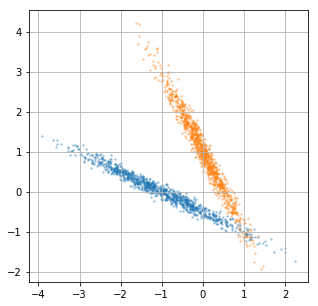

In [4]:
# Generate Data
N = 1000
mu1 = [-1.0, 0.0]
mu2 = [0.0, 1.0]
S1 = [[1.0, -0.5],[0.0, 0.1]]
S1 = np.dot(np.transpose(S1), S1) # make it positive semi-definite
S2 = [[0.1, 0.0],[-0.5, 1.0]]
S2 = np.dot(np.transpose(S2), S2)
data = np.concatenate((np.random.multivariate_normal(mu1, S1, N),
                       np.random.multivariate_normal(mu2, S2, N)))

plt.figure(figsize=(5, 5))
plt.scatter(data[:N, 0], data[:N,1], s=5, linewidths=0, alpha=0.5)
plt.scatter(data[N:, 0], data[N:,1], s=5, linewidths=0, alpha=0.5)
plt.grid()
x_range = np.linspace(np.amin(data[:, 0]), np.amax(data[:, 0]), num=100)
y_range = np.linspace(np.amin(data[:, 1]), np.amax(data[:, 1]), num=100)
X, Y = np.meshgrid(x_range, y_range)

Explained variance (kernel linear):
[ 0.64003181  0.35996819]
Explained variance (kernel rbf):
[ 0.54658103  0.45341897]


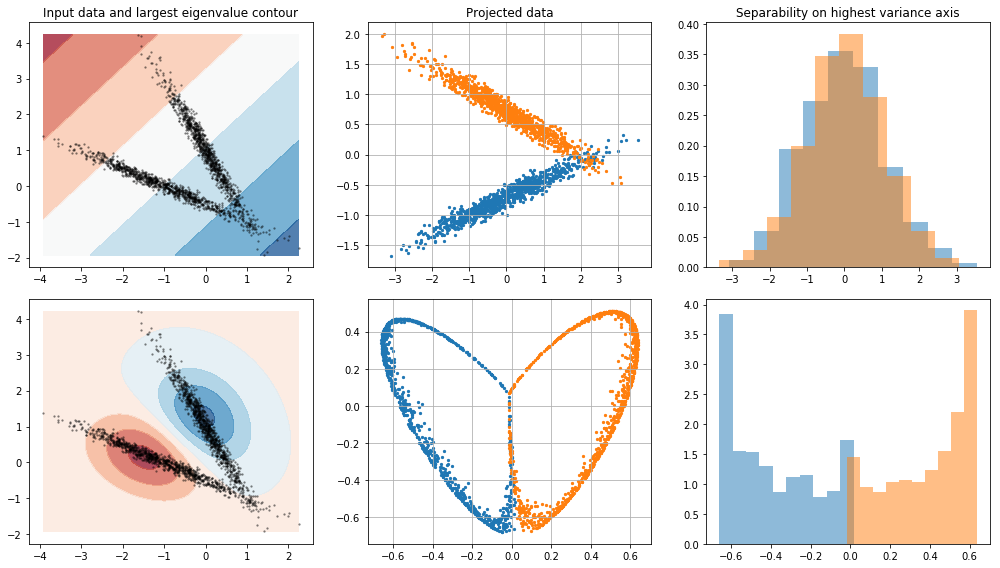

In [5]:
fig = plt.figure(figsize=(14, 8))

for k, kernel in enumerate(['linear', 'rbf']):
    pca = KernelPCA(n_components=2, kernel=kernel, gamma=1.0)
    pca.fit(data)
    print("Explained variance (kernel %s):" %(kernel))
    print(pca.lambdas_/np.sum(pca.lambdas_))
    I = np.argmax(pca.lambdas_)

    V_projected = np.zeros(shape=(X.shape[0], X.shape[1], 2))
    for i in range(X.shape[0]):
        V_projected[i, :, :] = pca.transform(np.stack([X[i,:],Y[i,:]]).T)

    ax = fig.add_subplot(2, 3, 3*k+1)
    #matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
    if k == 0:
        plt.title('Input data and largest eigenvalue contour')
    plt.contourf(X, Y, V_projected[:, :, I], alpha=0.75, cmap=plt.cm.RdBu)
    plt.scatter(data[:, 0], data[:,1], s=5, c='k', linewidths=0, alpha=0.5)

    data_proj = pca.transform(data)
    ax = fig.add_subplot(2, 3, 3*k+2)
    if k== 0:
        plt.title('Projected data')
    ax.scatter(data_proj[:N, 0], data_proj[:N, 1], s=5)
    ax.scatter(data_proj[N:, 0], data_proj[N:, 1], s=5)
    plt.grid()
    
    ax = fig.add_subplot(2, 3, 3*k+3)
    if k== 0:
        plt.title('Separability on highest variance axis')
    ax.hist(data_proj[:N, I], alpha=0.5, normed=True)
    ax.hist(data_proj[N:, I],  alpha=0.5, normed=True)
   
plt.tight_layout()